## This script test how to read nc file in parallel

In [1]:
from multiprocessing import Pool, RawArray
import os
import xarray as xr
import numpy as np
import time
import netCDF4 as nc
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import timeit

### 1. Old way to read nc file

In [11]:
# Example to read 2D variable 
# Try to read 15 day <10min GCM timestep> E3SM output
# Total 144*15 = 2160 files
start = time.time()
# Standard SP simulation (crm_nx=32, crm_dx=1200, crm_dt=5)
SP_Case = 'SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera'
SP_PATH = '/media/liran/Data3/SP/'
SP2008 = xr.open_mfdataset(SP_PATH+SP_Case+'.cam.h0.*.nc')
CLDLOWSP = SP2008.CLDLOW.values
end = time.time()
print(end - start)

961.5380711555481


In [3]:
CLDLOWSP.shape

(2161, 6144)

In [4]:
# Example to read 3D variable 
start = time.time()
# Standard SP simulation (crm_nx=32, crm_dx=1200, crm_dt=5)
SP_Case = 'SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera'
SP_PATH = '/media/liran/Data3/SP/'
SP2008 = xr.open_mfdataset(SP_PATH+SP_Case+'.cam.h0.*.nc')
TSP = SP2008.T.values
end = time.time()
print(end - start)

1188.0363268852234


### 2. Read the nc file in parellel

In [2]:
# A global dictionary storing the variables passed from the initializer.
var_dict = {}

def init_worker(X, X_shape):
    # Using a dictionary is not strictly necessary. You can also
    # use global variables.
    var_dict['X'] = X
    var_dict['X_shape'] = X_shape
    
# read 3D variables
def readT(i):
    days = "{0:0=2d}".format(i+1)
    SP_Case = 'SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera'
    SP_PATH = '/media/liran/Data3/SP/'
    print(SP_Case+'.cam.h0.2008-10-'+days+'*.nc\n')
    #print('parent process:', os.getppid(),'\n')
    #print('process id:', os.getpid(),'\n')
    SP2008 = xr.open_mfdataset(SP_PATH+SP_Case+'.cam.h0.2008-10-'+days+'*.nc')
    outarray = SP2008.T.values
    #print(outarray.shape)
    #print('finish id:', os.getpid(),'\n')
    a = outarray.reshape(-1)
    return a

# read 2D variables
def readCLDLOW(i):
    days = "{0:0=2d}".format(i+1)
    SP_Case = 'SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera'
    SP_PATH = '/media/liran/Data3/SP/'
    print(SP_Case+'.cam.h0.2008-10-'+days+'*.nc\n')
    #print('parent process:', os.getppid(),'\n')
    #print('process id:', os.getpid(),'\n')
    SP2008 = xr.open_mfdataset(SP_PATH+SP_Case+'.cam.h0.2008-10-'+days+'*.nc')
    outarray = SP2008.CLDLOW.values
    #print(outarray.shape)
    #print('finish id:', os.getpid(),'\n')
    timenum = 144
    colnum = 6144
    a = outarray.reshape(-1)
    return a

In [4]:
# Test the time to read 3D variable
start = time.time()
daynum = 15
timenum = 144
znum = 125
colnum = 6144
X_shape = (daynum, timenum*znum*colnum)
# Randomly generate some data
data = np.random.randn(*X_shape)
X = RawArray('d', X_shape[0] * X_shape[1])
# Wrap X as an numpy array so we can easily manipulates its data.
X_np = np.frombuffer(X, dtype=np.float64).reshape(X_shape)
# Copy data to our shared array.
np.copyto(X_np, data)
# start 15 worker processes
# NOTE HERE: I am reading 15 day simulation, so I set 15 works. 
# Depends on your data and HPC system, this number should be adjusted. 
# If there is enough cores, we can try 144 so every time step nc file are read simultaneously.
# This maybe a little agressive to the harddrive (Too many works ask to read from the same harddrive)
with Pool(processes=15, initializer=init_worker, initargs=(X, X_shape)) as pool:
    result3d = pool.map(readT, range(X_shape[0]))
    #print('Results (pool):\n', np.array(result3d))
    end = time.time()
    print(end - start)



SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-07*.nc
SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-03*.nc
SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-08*.nc
SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-04*.nc
SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-12*.nc
SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-14*.nc
SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16

In [6]:
# Test the time to read 2D variable
start = time.time()
daynum = 15
timenum = 144
colnum = 6144
X_shape = (daynum, timenum*colnum)
# Randomly generate some data
data = np.random.randn(*X_shape)
X = RawArray('d', X_shape[0] * X_shape[1])
# Wrap X as an numpy array so we can easily manipulates its data.
X_np = np.frombuffer(X, dtype=np.float64).reshape(X_shape)
# Copy data to our shared array.
np.copyto(X_np, data)
# start 15 worker processes
with Pool(processes=15, initializer=init_worker, initargs=(X, X_shape)) as pool:
    result2d = pool.map(readCLDLOW, range(X_shape[0]))
    #print('Results (pool):\n', np.array(result2d))
    end = time.time()
    print(end - start)

SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-02*.nc
SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-01*.nc
SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-03*.nc
SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-05*.nc
SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-04*.nc
SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-07*.nc
SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16

### Prepare to make plot

In [10]:
TSP1 = np.array(result3d)
TSP = TSP1.reshape((daynum, timenum,znum,colnum))

In [8]:
SPCLDLOW1 = np.array(result2d)
SPCLDLOW1 = SPCLDLOW1.reshape((daynum, timenum,colnum))

In [12]:
SPCLDLOW1_mean0      = np.mean(SPCLDLOW1, axis=0)
SPCLDLOW1_mean1      = np.mean(SPCLDLOW1_mean0, axis=0)
CLDLOWSP_mean        = np.mean(CLDLOWSP,axis=0)
CLDLOWSP_mean.shape

(6144,)

In [13]:
CERES_PATH = '/media/liran/Elements/CERES/'
sDay   = 1
count = 0
ndays = 15
iy = 2008
CERES_FAME = 'CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_Subset_'+str(iy)+'1001-'+str(iy)+'1130.nc'
CERES_FILE = nc.Dataset(CERES_PATH+CERES_FAME, mode = 'r')
# Read coordinates
lon_CERES  = CERES_FILE.variables['lon'] # 360
lat_CERES  = CERES_FILE.variables['lat'] # 180
time_CERES = CERES_FILE.variables['time']

In [14]:
# Read coordinates
SP2008 = xr.open_mfdataset('/media/liran/Data3/SP/SP_newsst_long_fluxout_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_x_120z1200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-15-73200.nc')
lon = SP2008.lon.values
lat = SP2008.lat.values
Z3 = SP2008.Z3.values
points6 = np.zeros([6144, 2])
points6[:,0] = lon
points6[:,1] = lat
xi = lon_CERES[:]
yi = lat_CERES[:]
Xi, Yi = np.meshgrid(lon_CERES, lat_CERES)

In [15]:
CLDLOWSP_ploti  = griddata(points6,SPCLDLOW1_mean1[:], (Xi, Yi), method='nearest')
CLDLOWSP_ploti_default  = griddata(points6,CLDLOWSP_mean[:], (Xi, Yi), method='nearest')

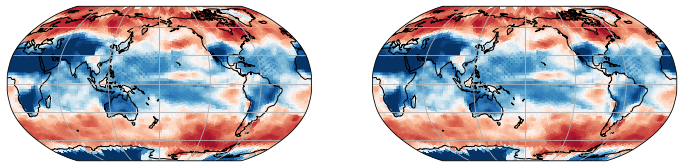

In [16]:
# Compare the Low cloud fraction
fs = 20
xi = lon_CERES[:]+180
yi = lat_CERES[:]
fig = plt.figure(figsize=(12,10))
levels2 = np.linspace(0, 1, 101)
    # --------------------
ax1 = fig.add_subplot(3,2,1, projection=ccrs.Robinson(central_longitude=180.0))
ax1.coastlines()
ax1.gridlines()
cntr1=ax1.contourf(xi, yi, CLDLOWSP_ploti, levels=levels2, cmap="RdBu_r",transform=ccrs.PlateCarree(central_longitude=180.0))

ax2 = fig.add_subplot(3,2,2, projection=ccrs.Robinson(central_longitude=180.0))
ax2.coastlines()
ax2.gridlines()
cntr2=ax2.contourf(xi, yi, CLDLOWSP_ploti_default, levels=levels2, cmap="RdBu_r",transform=ccrs.PlateCarree(central_longitude=180.0))
